# Solving a mincost SAT problem using QAOA

$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$

We want to find an (almost) optimal configuration in an attributed feature model.

The system can be described by the following boolean formulae:
$
(x_1 \vee x_2) \wedge (x_3 \oplus x_4) \wedge (x_5 \implies x_6)
\iff
(x_1 \vee x_2) \wedge (\neg x_3 \vee \neg x_4) \wedge (x_3 \vee x_4) \wedge (\neg x_5 \vee x_6)
$

The right hand side is in conjunctive normal form (CNF).

Furthermore, there is an implementation cost associated with each feature, as shown in the table below.

| Feature | Cost $c_i$ |
| --- | --- |
| $x_1$ | 30 |
| $x_2$ | 20 |
| $x_3$ | 25 |
| $x_4$ | 50 |
| $x_5$ | 10 |
| $x_6$ | 10 |


# Quantum Approximation Optimization Algorithm
Approximates the solution of an combinatorial optimization problem consisting of:
- $n$ binary variables
- $m$ clauses
- objective function $C(z)$

The domain of the problem is unconstrained, thus the algorithms goal is to find an (almost) optimal bistring $z=z_1...z_n$

It refines VQA and uses the Alternating Operator Ansatz.
The algorithm consists of a classical and quantum part.

On a quantum computer a circuit is constructed which is parameterized by $\gamma$ and $\beta$.
Initially the uniform superposition state $H^{\otimes n}$ is prepared.

Two operators $U(C,\gamma)$ and $U(B,\beta)$ are constructed.
The phase-separating operator $U(C,\gamma)$ encodes $C$  and applies a phase shift $e^{-i\gamma}$ on every computational basis state for every clause that is fulfilled.
The mixing operator $U(B, \beta)$ changes the amplitude of solutions using rotation $R_x$.

Both $U(C,\gamma)$  and $U(B,\beta)$ are then applied $p$ times according to the hyper-parameter $p \in \mathbf{N}$.
Finally measurements gates are added.

The circuit has a shallow circuit depth of at most $mp+m$.

On a classical computer the cost of $C(z)$ for the current evaluation is evaluated.
Either the process is terminated if the termination condition is met ($C(z)$ is sufficiently low), or the parameters $\gamma$ and $\beta$ are optimized classically.

$-2\pi\lt\gamma\lt2\pi$ and $-\pi\lt\beta\lt\pi$


## Quantum circuit
We start by defining the parameteriezed circuit.

In [141]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
# Notebook Setup
from IPython.core import page
page.page = print

# Imports used for examples
from qiskit.visualization import plot_histogram
from pprint import pprint

### Initialization
Uniform superposition by applying Hadamard gates $H$ on every qubit.

In [142]:
# Uniform Superposition Initialization
from fragments.quantum_states import superposition_circuit, add_all_hadamards
%psource superposition_circuit
%psource add_all_hadamards

def superposition_circuit(nqubits: int) -> QuantumCircuit:
    """
        Create a new quantum circuit where all qubits are initialized to |+>
    """
    qc_0 = QuantumCircuit(nqubits)
    return add_all_hadamards(qc_0, range(nqubits))

def add_all_hadamards(qc, nqubits):
    """
        Apply an H-gate to all 'qubits' in qc
    """
    for q in nqubits:
        qc.h(q)
    return qc



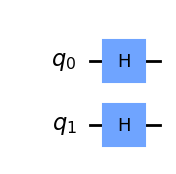

In [143]:
superposition_circuit(2).draw(output="mpl")

### Mixing operator
The mixing operator $U(B, \beta)$ applies a rotation around $X$ of $2*\beta$ on every qubit using $R_x$ gates.

In [144]:
# Mixer Hamiltonian
from qaoa_mincost_sat import mixer_circuit
%psource mixer_circuit

def mixer_circuit(nqubits: int) -> QuantumCircuit:
    beta = Parameter("$\\beta$")
    qc_mix = QuantumCircuit(nqubits)
    for i in range(0, nqubits):
        qc_mix.rx(2 * beta, i)
    return qc_mix, beta



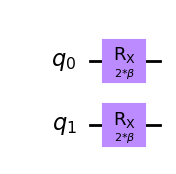

In [145]:
example_qc_mixer, _ = mixer_circuit(2)
example_qc_mixer.draw(output="mpl")

### Phase-separating operator
The phase-separating operator $U(C,\gamma)$ encodes $C$ and can be derived from a cost Hamiltonian $H_{Ctot}$ in Ising-form. 
We can describe $H_{Ctot}$ in a form where for $m$ clauses operating on one or two qubits (because the domain is unconstrained) the values of $C$ are encoded.
We later describe how such a Hamiltonian can be constructed for our concrete problem class.

In [146]:
# Hamiltonians may be described as a dict of tuples describing acting qubits and a value for each clause
# hamiltonian = {(q1?, q2?, ...) : factor}
sat_hamiltonian = {
    () : 1,
    (0,): 0.25,
    (1,): 0.25,
    (4,): -0.25,
    (5,): 0.25,
    (0, 1): 0.25,
    (2, 3): 0.5,
    (4, 5): -0.25
}

Clauses on one qubits are then translated into $R_z$ rotations and clauses on two qubits are translated into the symmetric $R_{zz}$ gate.

In [147]:
# Cost Hamiltonian
from qaoa_mincost_sat import problem_circuit
%psource problem_circuit

def problem_circuit(hamiltonian, nqubits: int) -> QuantumCircuit:
    gamma = Parameter("$\\gamma$")
    qc_p = QuantumCircuit(nqubits)
    normalization = math.pi/max(hamiltonian.values())
    
    for key, factor in hamiltonian.items():
        acting_qubits = len(key)
        
        if acting_qubits == 0:
            pass # identity case
        elif acting_qubits == 1:
            # single qubit term
            q1 = key[0]
            qc_p.rz(2 * normalization * factor * gamma, q1)
        elif acting_qubits ==2:
            # quadratic qubit term
            q1 = key[0]
            q2 = key[1]
            qc_p.rzz(2 * normalization * factor * gamma, q1, q2)
        else:
            # non quadratic, error
            RuntimeError(f"Non quadratic term in hamiltonian: {key, factor}")
            
    return qc_p, gamma



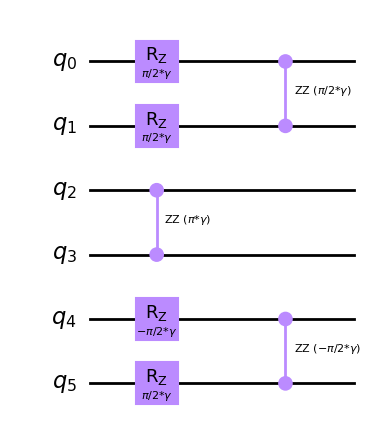

In [148]:
example_qc_problem, _ = problem_circuit(sat_hamiltonian, 6)
example_qc_problem.draw(output="mpl")

### QAOA circuit
Now we can create a QAOA circuit for a problem hamiltonian.

The circuit can also be warmstarted by initializing a specific state $\ket{s}$ instead of a uniform superposition.

In [149]:
# QAOA Circuit
from qaoa_mincost_sat import qaoa_circuit
%psource qaoa_circuit

def qaoa_circuit(hamiltonian, nqubits, nlayers, amplitude_vector=None, measure=True) -> QuantumCircuit:
    if amplitude_vector is not None:
        # warm start
        qc = QuantumCircuit(nqubits) 
        qc.initialize(amplitude_vector)
    else:
        # equal superposition
        qc = superposition_circuit(nqubits)
        
    qg_mixer, beta = mixer_circuit(nqubits)
#     qg_mixer.name = "Mixer"
    qg_problem, gamma = problem_circuit(hamiltonian, nqubits)
#     qg_problem.name = "Problem"
    
    for l in range(nlayers):
        qc.barrier()
        qc = qc.compose(qg_problem)
        qc.barrier()
        qc = qc.compose(qg_mixer)

    if measure:
        qc.measure_all()
    return qc, beta, gamma



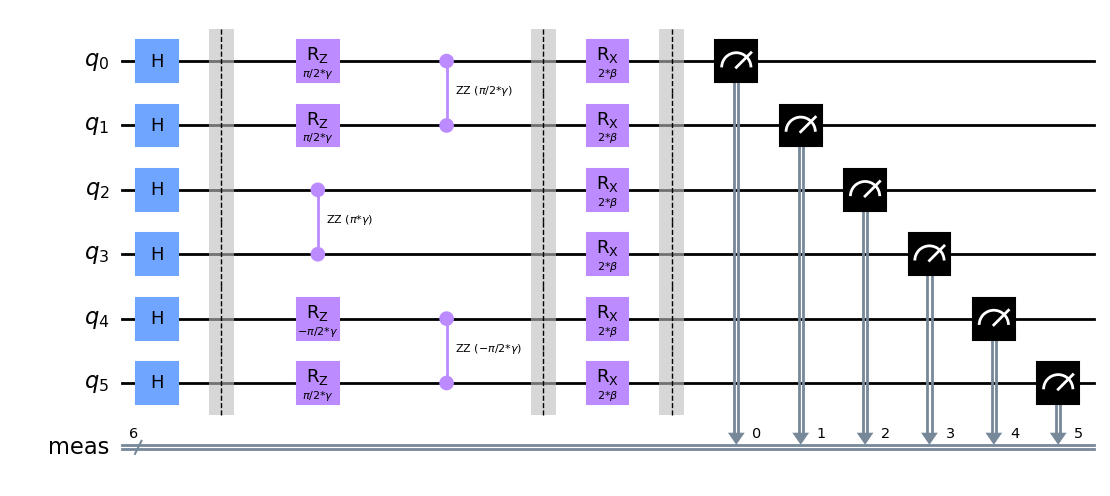

In [150]:
example_qaoa_circuit, _, _ = qaoa_circuit(sat_hamiltonian, 6, 1)
example_qaoa_circuit.draw(output="mpl")

### Quantum routine
Executes QAOA circuit an returns circuit and results

In [151]:
# QAOA Quantum Procedure
from qaoa_mincost_sat import quantum
%psource quantum

def quantum(hamiltonian, nqubits, layers, beta_val, gamma_val, shots=512, amplitude_vector=None):
    qc, beta, gamma = qaoa_circuit(hamiltonian, nqubits, layers, amplitude_vector)
        
    # Set parameters for qc
    qc = qc.bind_parameters({
        beta: beta_val,
        gamma: gamma_val
    })

    # run and measure qc
    qasm_sim = Aer.get_backend('qasm_simulator')
    transpiled_qaoa = transpile(qc, qasm_sim)
    results = qasm_sim.run(transpiled_qaoa, shots=shots).result()
    counts = results.get_counts()

    return counts, qc



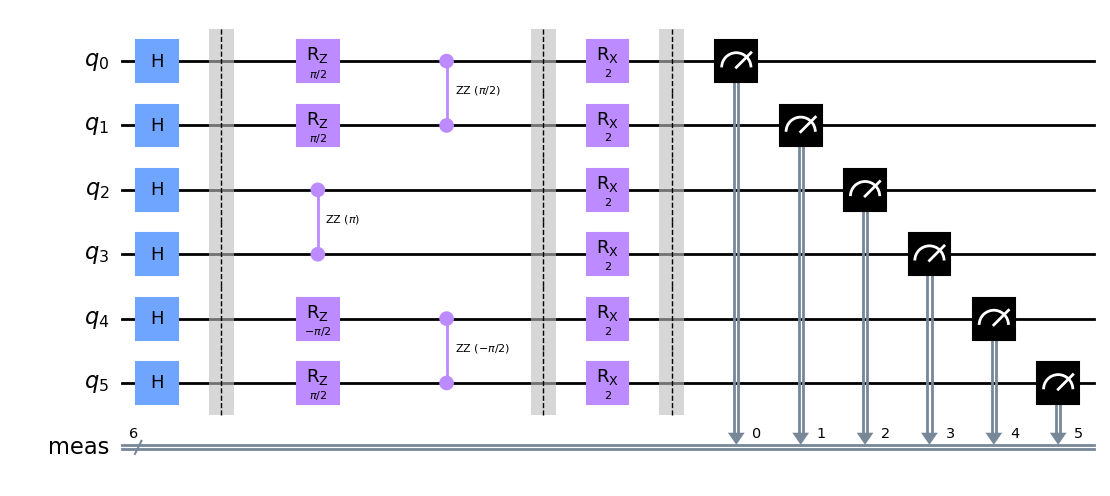

In [152]:
counts, qc = quantum(sat_hamiltonian, 6, 1, 1, 1)
qc.draw(output="mpl")

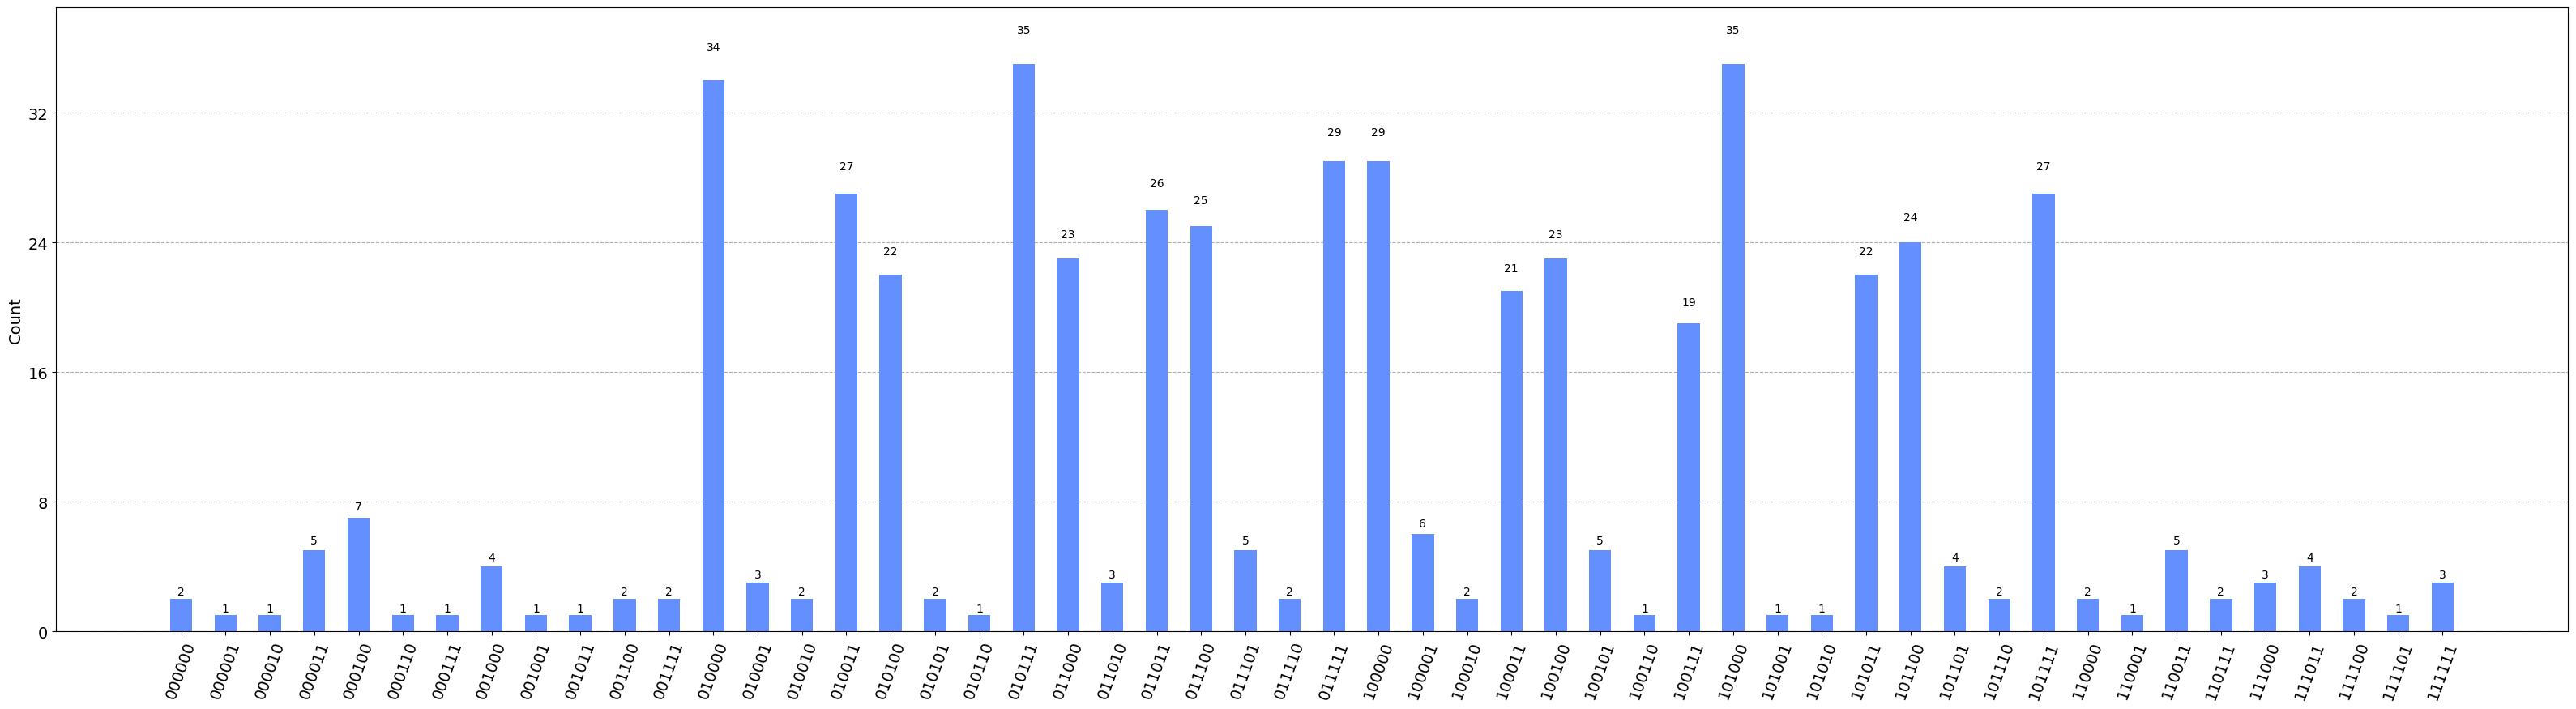

In [153]:
plot_histogram(counts, figsize=(40, 10))

## Creating a problem specific Hamiltonian

### Creating a cost function satisfying features

[Glover](https://arxiv.org/abs/1811.11538) described quadratic penalties for the 2-SAT problem by treating inputs as $0/1$ values, forming a traditional constraint and then deriving a quadratic penalty. We summarize their work here:

| Clause Type | Example | Constraint | Penalty |
|---|---|---|---|
| No Negations  | $$(x_i \vee x_j)$$               | $$x_i + x_j = 1$$            | $$(1 - x_i - x_j + x_i x_j)$$
| One Negation  | $$(x_i \vee \lnot{}x_j)$$        | $$x_i + (1-x_j) \geq 1$$     | $$(x_j - x_i x_j)$$
| Two Negations | $$(\lnot{}x_i \vee \lnot{}x_j)$$ | $$(1-x_i) + (1-x_j) \geq 1$$ | $$(x_i x_j)$$


Using these penalties we can transform our example into a QUBO model.

$$
min~y(x) = 2-x_1-x_2-x_3-x_4+x_5+x_1*x_2+2*x_3*x_4-x_5*x_6
$$

$y(x)$ is the integer of unsatisfied clauses. In other words, $y=0$ indicates that all clauses are satisfied, which is desired for this problem.

### Creating a cost function for feature costs

For the feature costs, we can formulate a sum that adds a features cost if it is in the input vector x.
$$
k(x) = \sum_{x}^{} c_i x_i
$$


### Combining the functions
In our example, we want to find a valid configuration with the minimum cost, so we sum the two previous functions and add a penalty factor $\alpha$ to be able to change the influence of our SAT constraints.

$$
min~f(x) = k(x) + \alpha y(x)
$$

We assume $\alpha \gg 0$, the exact value probably depends on the value of $k(x)$.

### Forming Hamiltonians
We got our QUBO cost function defined. We now need to transform the Binary input space $x_i \in \{0,1\}$ to the Ising Spin model of $s_i \in \{-1, 1\}$. 

Replace $x_i$ with $S_i = 2x_i-1$ meaning $x_i = \frac{1 - S_i}{2}$ (Note that switching the sign changes the eigenvectors)

#### Cost Hamiltonian for the SAT part
Before applying it to the entire function, let's first consider only $min~y(x)$.

Ising Form:
$$
min~y(s) = 2-\frac{1-s_1}{2}-\frac{1-s_2}{2}-\frac{1-s_3}{2}-\frac{1-s_4}{2}+\frac{1-s_5}{2}+\frac{1-s_1}{2}*\frac{1-s_2}{2}+2*\frac{1-s_3}{2}*\frac{1-s_4}{2}-\frac{1-s_5}{2}*\frac{1-s_6}{2}
$$
Simplified to (not really needed):
$$ 
min~y(s) = (4 + s_2 + s_1 (1 + s_2) + 2 s_3 s_4 + s_6 - s_5 (1 + s_6))*\frac{1}{4}
$$
Which expands to:
$$
min~y(s) = 1 + s_1\frac{1}{4} + s_2\frac{1}{4} + s_1 s_2\frac{1}{4} + s_3 s_4 \frac{1}{2} - s_5\frac{1}{4} + s_6\frac{1}{4} - s_5 s_6 \frac{1}{4}
$$
And leaves us with a cost hamiltonian $H_C$ with Pauli-Z-Gates $\sigma^z_i$ and an Identity $I$ on the global phase(?):
$$
H_C = 1*I + \sigma^z_1\frac{1}{4} + \sigma^z_2\frac{1}{4} + \sigma^z_1 \sigma^z_2\frac{1}{4} + \sigma^z_3 \sigma^z_4 \frac{1}{2} - \sigma^z_5\frac{1}{4} + \sigma^z_6\frac{1}{4} - \sigma^z_5 \sigma^z_6 \frac{1}{4}
$$

#### Cost Hamiltonian for the feature costs
We can expand the feature costs in our example according to the table above.
$$
min~k(x) = \sum_{x}^{} c_i x_i \\
= 30*x_1 + 20*x_2 + 25*x_3 + 50*x_4 + 30*x_5 + 10*x_6
$$
Which we then again transform into Ising form.

$$
min~k(s) = 15*(1-s_1) + 10*(1-s_2)+ 12.5*(1-s_3) + 25*(1-s_4) + 15*(1-s_5) + 5*(1-s_6) \\
min~k(s) = 82.5 - 15 s_1 - 10 s_2 - 12.5 s_3 - 25 s_4 - 15 s_5 - 5 s_6
$$

Which leaves us with our cost Hamiltonian $H_{Ck}$
$$
H_{Ck} = 82.5 I - 15 \sigma^z_1 - 10 \sigma^z_2 - 12.5 \sigma^z_3 - 25 \sigma^z_4 - 15 \sigma^z_5 - 5 \sigma^z_6
$$

#### Combining Hamiltonians

All that's left to do is choosing a suitable $\alpha$ and combining the functions.

We choose $\alpha = 1000$ as a first guess ($82.5 * 10$ rounded up).

$$
H_{Ctot} = H_{Ck} + \alpha ~ H_C
$$

$$
H_{Ctot} = 82.5 I - 15 \sigma^z_1 - 10 \sigma^z_2 - 12.5 \sigma^z_3 - 25 \sigma^z_4 - 15 \sigma^z_5 - 5 \sigma^z_6  + 1000*I + \sigma^z_1 250 + \sigma^z_2 250 + \sigma^z_1 \sigma^z_2 250 + \sigma^z_3 \sigma^z_4 500 - \sigma^z_5 250 + \sigma^z_6 250 - \sigma^z_5 \sigma^z_6 250
$$

simplified to

$$
H_{Ctot} = 1082.5 I + 250 \sigma^z_1 \sigma^z_2 + 235 \sigma^z_1 + 240 \sigma^z_2 + 500 \sigma^z_3 \sigma^z_4 - 12.5 \sigma^z_3 - 25 \sigma^z_4 - 250 \sigma^z_5 \sigma^z_6 - 265 \sigma^z_5 + 245 \sigma^z_6
$$

We can implement such a Hamiltonian $H_{Ctot}$ using the `qubovert` library and solve small instances via bruteforce.

In [154]:
from util.hamiltonian_math import solve_bruteforce
%psource solve_bruteforce

def solve_bruteforce(model):
    model_solution = model.solve_bruteforce()
    print("Variable assignment:", model_solution)
    print("Model value:", model.value(model_solution))
    print("Constraints satisfied?", model.is_solution_valid(model_solution)) # we don't have constraints in our model



In [155]:
from qubovert import spin_var
# define spin variables 
z1, z2, z3, z4, z5, z6 = spin_var('z1'), spin_var('z2'), spin_var('z3'), spin_var('z4'), spin_var('z5'), spin_var('z6')

# Our manually calculated hamiltonian
feetcost_model = 1082.5 + 250 * z1 * z2 + 235 * z1 + 240 * z2 + 500 * z3 * z4 - 12.5 * z3 - 25 * z4 - 250 * z5 * z6 - 265 * z5 + 245 * z6
solve_bruteforce(feetcost_model)

Variable assignment: {'z1': 1, 'z2': -1, 'z3': -1, 'z4': 1, 'z5': 1, 'z6': 1}
Model value: 45.0
Constraints satisfied? True


We can also define the SAT ($H_C$) and cost ($H_{Ck}$) Hamiltonians separately and combine them afterwards.

In [156]:
# cost and sat individually
from qubovert import boolean_var

# define binary vars
x1, x2, x3, x4, x5, x6 = boolean_var('x1'), boolean_var('x2'), boolean_var('x3'), boolean_var('x4'), boolean_var('x5'), boolean_var('x6')

# SAT Penalty
alpha_sat = 100 # 1e6

# SAT QUBO
sat_model = alpha_sat * (2 - x1 - x2 - x3 - x4 + x5 + x1 * x2 + 2 * x3 * x4 - x5 * x6)

# Cost QUBO
cost_model = 30*x1 + 20*x2 + 25*x3 + 50*x4 + 30*x5 + 10*x6

# Combine models
combined_model = sat_model +  cost_model
print("QUBO Combined Model:")
pprint(combined_model)
print("Ising Combined Model: ")
combined_hamiltonian = combined_model.to_quso()
print(combined_hamiltonian)

solve_bruteforce(combined_model)

QUBO Combined Model:
{(): 200,
 ('x1',): -70,
 ('x1', 'x2'): 100,
 ('x2',): -80,
 ('x3',): -75,
 ('x3', 'x4'): 200,
 ('x4',): -50,
 ('x5',): 130,
 ('x5', 'x6'): -100,
 ('x6',): 10}
Ising Combined Model: 
{(0,): 10.0, (): 182.5, (1,): 15.0, (2,): -12.5, (3,): -25.0, (4,): -40.0, (0, 1): 25.0, (2, 3): 50.0, (4, 5): -25.0, (5,): 20.0}
Variable assignment: {'x1': 0, 'x2': 1, 'x3': 1, 'x4': 0, 'x5': 0, 'x6': 0}
Model value: 45
Constraints satisfied? True


## Classical Routine
On the classical side we now need functions to evaluate $C$, which correspond to computing the energy of the Hamiltonian for a specific measured output (a configuration in our case) by `compute_config_energy`.

In [157]:
from util.hamiltonian_math import compute_config_energy
%psource compute_config_energy

def compute_config_energy(hamiltonian, config: str):
    """
        Computes the energy for a given configuration (ising input) of a given hamiltonian (ising form)
    """
    energy = 0
    for key, factor in hamiltonian.items():
        acting_qubits = len(key)

        if acting_qubits == 0:
            # identity case
            energy += factor
        elif acting_qubits == 1:
            # single qubit term
            q1 = key[0]
            energy += factor * config[q1]
        elif acting_qubits ==2:
            # quadratic qubit term
            q1 = key[0]
            q2 = key[1]
            energy += factor * config[q1] * config[q2]
        else:
            # non quadratic, error
            raise RuntimeError(f"Non quadratic term in hamiltonian: {key, factor}")
    return energy



As the circuit is executed multiple times the function `compute_hamiltonian_energy` can be used with different strategies.
Currently, we provide average, top and minimum strategies and the best one to use is TBD.

In [158]:
from util.hamiltonian_math import compute_hamiltonian_energy, hamiltonian_strategy_average, hamiltonian_strategy_top, hamiltonian_strategy_min
%psource compute_hamiltonian_energy
%psource hamiltonian_strategy_average
%psource hamiltonian_strategy_top
%psource hamiltonian_strategy_min

def compute_hamiltonian_energy(hamiltonian, counts, strategy='avg'):
    """
        Compute the energy state of a hamiltonian from measurements.
        
        :param hamiltonian: the hamiltonian (QUBO) describing the system
        :param counts: measurement results for a quantum system for the hamiltonian
        :param strategy: method for actually evaluating the hamiltonian. Available: 'avg', 'top', 'min'
    """
    if strategy == 'avg':
        return hamiltonian_strategy_average(hamiltonian, counts)
    elif strategy == 'top':
        return hamiltonian_strategy_top(hamiltonian, counts)
    elif strategy == 'min':
        return hamiltonian_strategy_min(hamiltonian, counts)
    else:
        raise RuntimeError(f"Unsupported strategy: {strategy}")

def hamiltonian_strategy_average(hamiltonian, counts):
    """
        Computes the average energy across the entire measurement for the given hamiltonian
    """
    average_energy = 0
    for config_str in counts.keys():
        #

We can then define a function that given a beta and gamma as input creates a quantum circuit, executes it multiple times and returns the energy.

This function can be used in a classical optimizer.

In [159]:
from qaoa_mincost_sat import get_expectation
%psource get_expectation

def get_expectation(hamiltonian, nqubits, nlayers, shots=128, amplitude_vector=None):
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        qc, beta, gamma = qaoa_circuit(hamiltonian, nqubits, nlayers, amplitude_vector)
        
        # Set parameters for qc
        qc = qc.bind_parameters({
            beta: theta[0],
            gamma: theta[1]
        })
        
        counts = backend.run(qc, nshots=shots).result().get_counts()
        return compute_hamiltonian_energy(hamiltonian, counts, strategy='min')
    
    return execute_circ



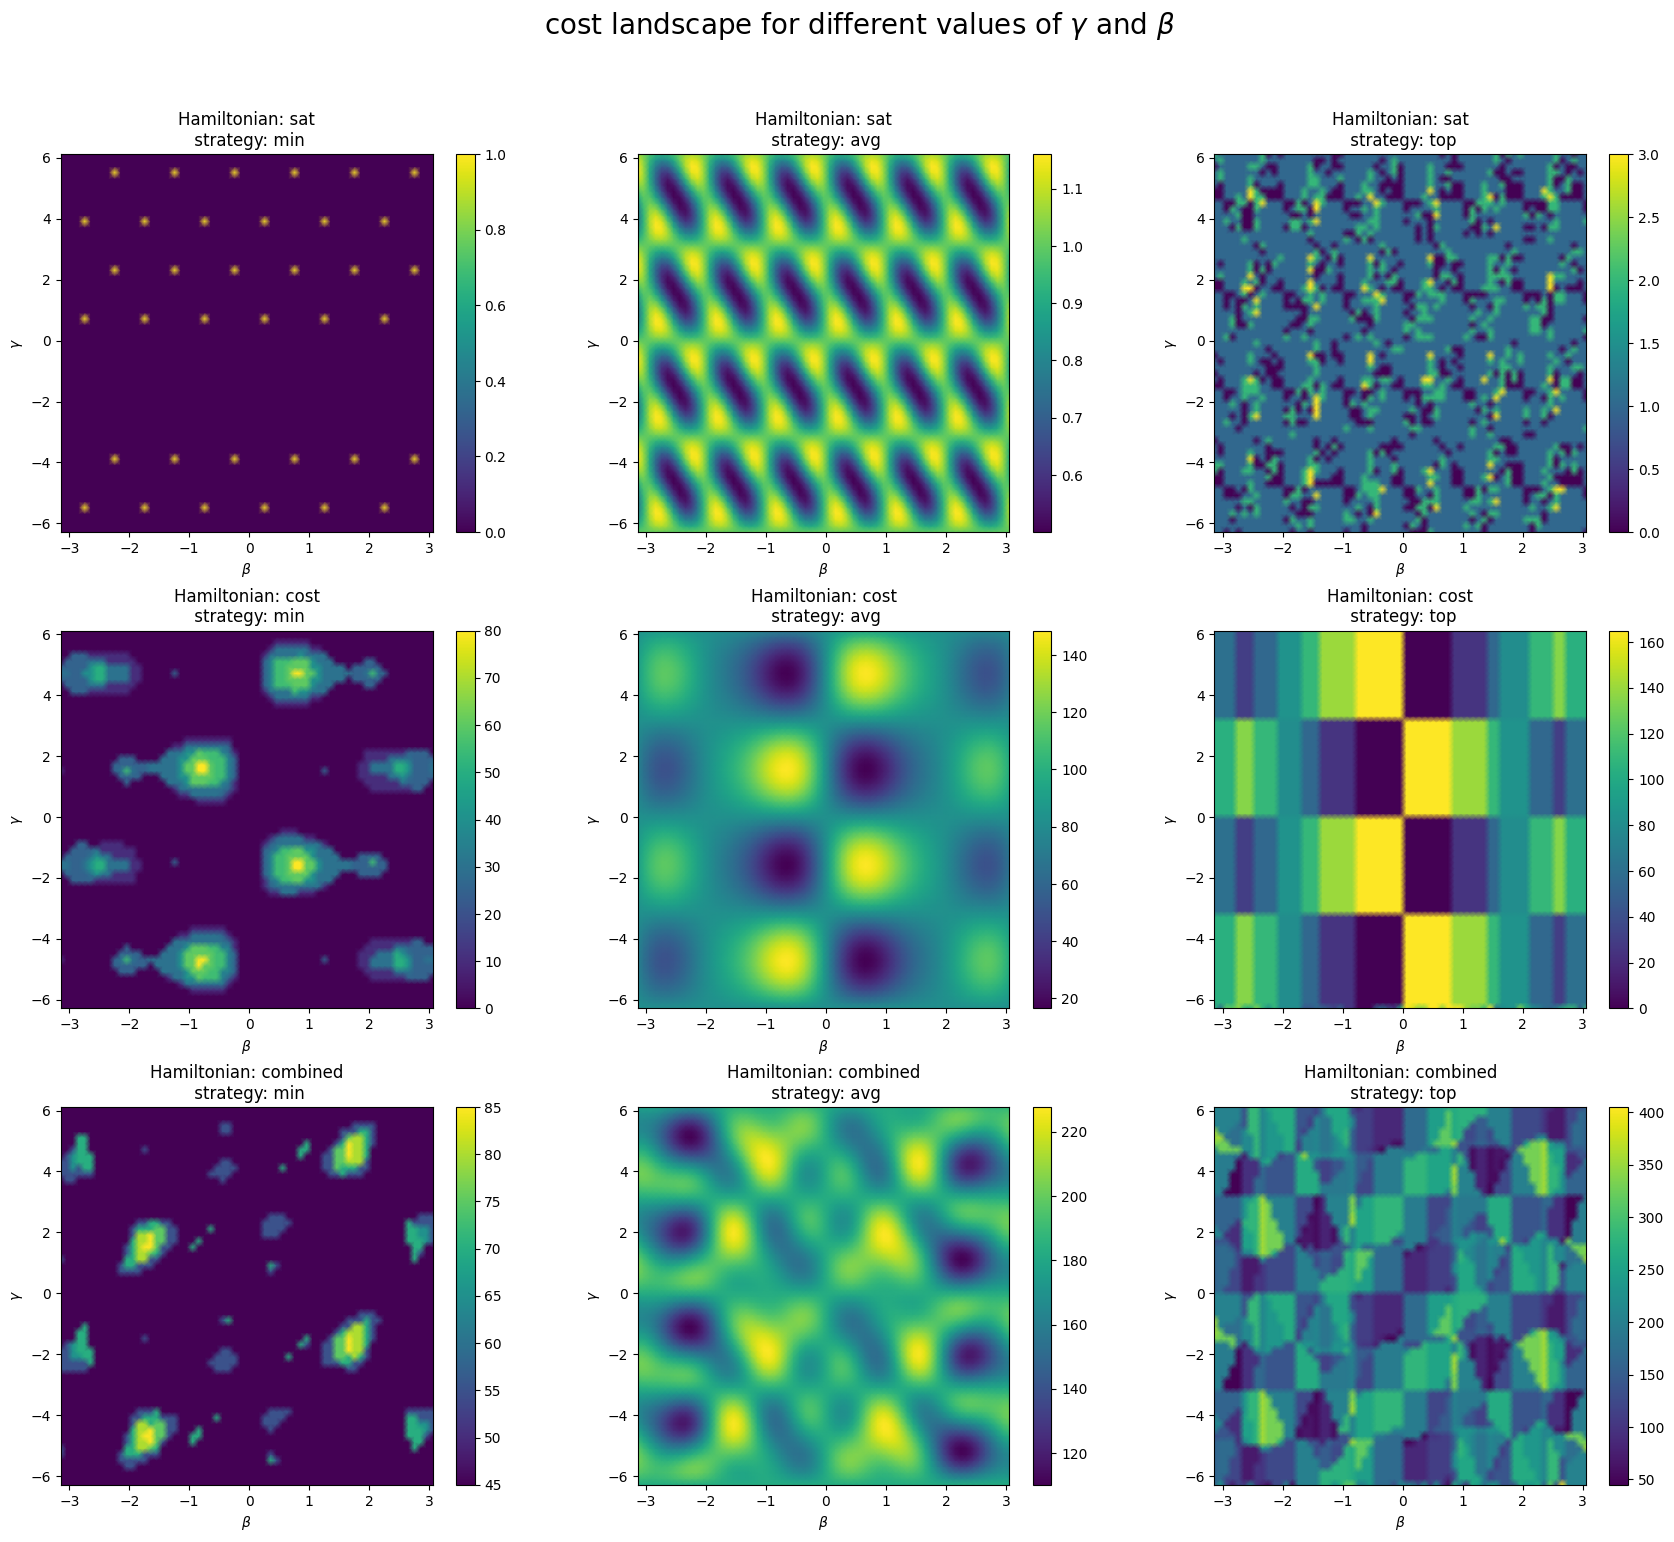

In [160]:
# Plot cost landscape for different values of beta and gamma
import math
import numpy as np
import sys
from qiskit_aer import StatevectorSimulator
from util.hamiltonian_math import compute_hamiltonian_energy_from_statevector

backend = StatevectorSimulator()

plot_arguments = [{"hamiltonian": sat_hamiltonian, "strategy": 'min'},
                  {"hamiltonian": sat_hamiltonian, "strategy": 'avg'},
                  {"hamiltonian": sat_hamiltonian, "strategy": 'top'},
                  {"hamiltonian": cost_model.to_quso(), "strategy": 'min'},
                  {"hamiltonian": cost_model.to_quso(), "strategy": 'avg'},
                  {"hamiltonian": cost_model.to_quso(), "strategy": 'top'},
                  {"hamiltonian": combined_hamiltonian, "strategy": 'min'},
                  {"hamiltonian": combined_hamiltonian, "strategy": 'avg'},
                  {"hamiltonian": combined_hamiltonian, "strategy": 'top'}]

step_size = 0.1
x_axis = np.arange(-math.pi, math.pi, step_size)
y_axis = np.arange(-2 * math.pi, 2 * math.pi, 2 * step_size)

fig, axes = plt.subplots(3, 3, figsize=(18, 16))
fig.suptitle(r"cost landscape for different values of $\gamma$ and $\beta$", fontsize=20)
fig.tight_layout(pad=5.0)
cmap = "viridis"

for ax, arguments in zip(axes.ravel(), plot_arguments):
    if arguments["hamiltonian"] == sat_hamiltonian:
        ax.set_title(f"Hamiltonian: sat\n strategy: {arguments['strategy']}")
    elif arguments["hamiltonian"] == cost_model.to_quso():
        ax.set_title(f"Hamiltonian: cost\n strategy: {arguments['strategy']}")
    else:
        ax.set_title(f"Hamiltonian: combined\n strategy: {arguments['strategy']}")
    ax.set_xlabel(r"$\beta$")
    ax.set_ylabel(r"$\gamma$")

    hamiltonian = arguments["hamiltonian"]

    expectation = np.zeros(shape=(len(x_axis), len(y_axis)))
    expectation_max = -sys.maxsize - 1
    expectation_min = sys.maxsize

    for i_index, i in enumerate(x_axis):
        for j_index,j in enumerate(y_axis):
            qc, beta, gamma = qaoa_circuit(hamiltonian, 6, 1, measure=False)

            qc = qc.bind_parameters({
                beta: i,
                gamma: j
            })

            result = backend.run(qc).result()

            statevector = result.get_statevector()
            value = compute_hamiltonian_energy_from_statevector(hamiltonian, statevector, 6, strategy=arguments["strategy"])
            expectation[i_index][j_index] = value

            if expectation_max < value:
                expectation_max = value
            elif expectation_min > value:
                expectation_min = value

    pcm = ax.pcolormesh(x_axis, y_axis, expectation, shading="gouraud", cmap=cmap, vmin=expectation_min, vmax=expectation_max)
    plt.colorbar(pcm, ax=ax)

plt.show()

## Applying QAOA
Finally, we can run the whole algorithm for a specific problem Hamiltonian.

In [161]:
from qaoa_mincost_sat import apply_qaoa
%psource apply_qaoa

def apply_qaoa(hamiltonian, layers=60, n_features=6, shots=256, theta={"beta": 0.01, "gamma": -0.01}, warmstart_statevector=None, use_optimizer=True):
    """
        Applies the QAOA Algorithm for the given problem hamiltonian in QUBO form.
        
        :param int layers: the hyperparameter p of QAOA defining how many cost-mixer-layers will be in the circuit
        :param int n_features: the number of independent variables in the input hamiltonian
        :param int shots: the number of shots used in a simulator run of the QAOA quantum circuit
        :param dict theta: dictionary with keys "beta" and "gamma" that parameterize the QAOA circuit, used as start value when optimizing
        :param list warmstart_statevector: statevector to warmstart to, instead of creating an equal superposition
        :param bool use_optimizer: indicates whether to optimize theta using classical optimizers
    """
    # define expectation function for optimizers
    expectation = get_expectation(h

In [162]:
# QAOA Example Application Using Optimizer
hamiltonian = combined_hamiltonian # min-cost SAT
# hamiltonian = sat_model.to_quso()   # just SAT

# warmstart array for specific SAT instance of this notebook
warmstart_statevector = \
      [0.        , 0.        , 0.        , 0.        , 0.        ,
       0.232379  , 0.28809721, 0.20976177, 0.        , 0.25298221,
       0.19493589, 0.24899799, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.20976177, 0.17888544, 0.23021729,
       0.        , 0.24899799, 0.23664319, 0.29664794, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.23021729, 0.24083189,
       0.26267851, 0.        , 0.232379  , 0.20248457, 0.20736441,
       0.04472136, 0.        , 0.        , 0.        ]

layers = 60 # more layers = higher approximation rate but more quantum errors when running on real qpu
n_features = 6
shots = 256
theta = {"beta": 0.01, "gamma": -0.01} # start values for optimization
use_warmstart = False
use_optimizer = True

if not use_warmstart:
    warmstart_statevector = None

counts, qc = apply_qaoa(hamiltonian, layers, n_features, shots, theta, warmstart_statevector, use_optimizer)

     fun: 45.0
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 29
  status: 1
 success: True
       x: array([ 0.01, -0.01])


In [163]:
# qc.draw(output="mpl")

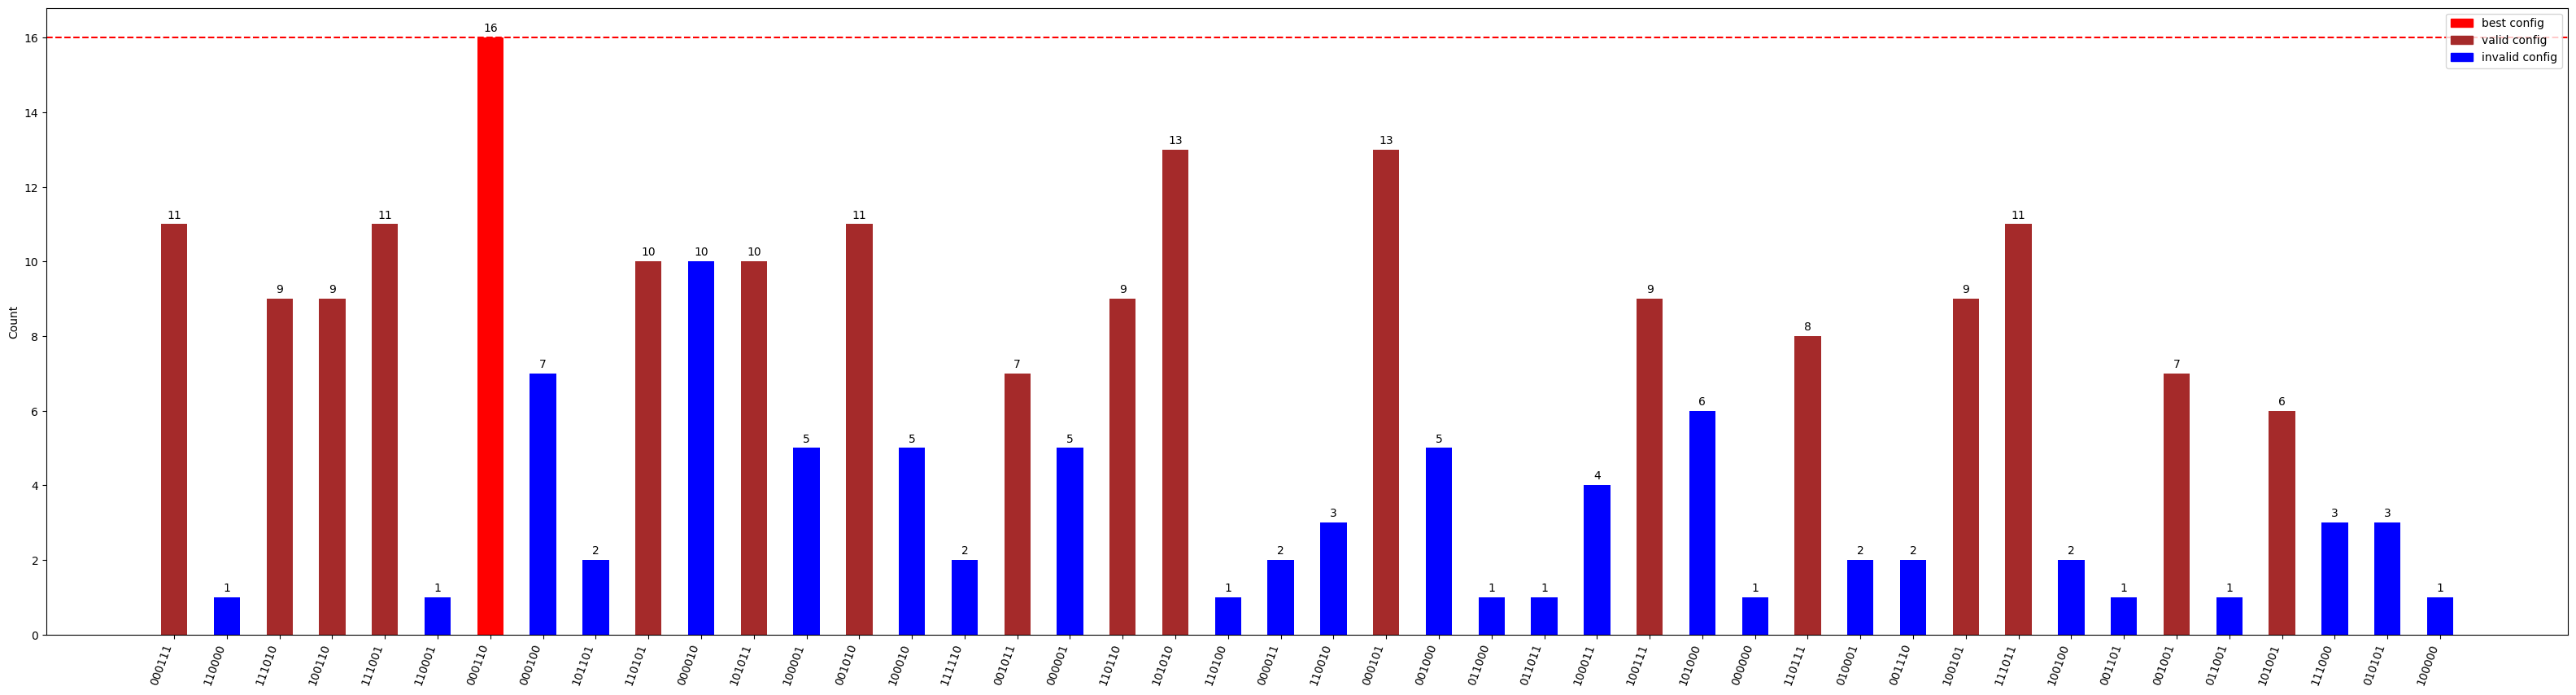

In [164]:
# Pretty Print the results of the previous Cell

best_config = "000110" # 654321
valid_configs = ["101010", "101001", "101011", "100110", "100101", "100111", "001010", "001001", "001011", "000101", "000111", "111010", "111001", "111011", "110110", "110101", "110111"]

col = []
for key in counts.keys():
    if key==best_config:
        col.append('r')
    elif valid_configs.__contains__(key):
        col.append("brown")
    else:
        col.append('b')

plt.rcParams["figure.figsize"] = (40,10)
plt.ylabel("Count")
plt.xticks(rotation=70, ha="right")
plt.bar(counts.keys(), counts.values(), width=0.5, color=col)

max_count = 0
for val in counts.values():
    if val > max_count:
        max_count = val

for i, val in enumerate(counts.values()):
    plt.text(x=i, y=val+max_count/100, s=f"{val}", fontdict=dict(fontsize=10), horizontalalignment="center")

plt.axhline(y=max_count, color='r', linestyle='--')

red_patch = mpatches.Patch(color='r', label="best config")
brown_patch = mpatches.Patch(color="brown", label="valid config")
blue_patch = mpatches.Patch(color='b', label="invalid config")
plt.legend(handles=[red_patch, brown_patch, blue_patch], loc="upper right")

plt.show()